In [122]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
import matplotlib.pyplot as plt
import os
import numpy as np

In [124]:
omp = 1
mpi_run = 'mpirun -np 8'

# RT analysis of GaAs

In this notebook we analyze the dynamics of the spin polarization for $k$-points.

In particular we analyze the single point dynamics of the points kmax and kmed 
to undestand the behavior of the dynamics under various pump conditions. The aim
of this analysis is mainly to understand if there is a pump configuration that is
able to change sign to a component of the signal. This condition can realize the
echo mechanism in the multi $k$-points configuration.

In [125]:
kpoints = {
    'kmax': {
        'source_dir' : 'NSCF/T_4.36-bnds_16.save',
        'run_dir' : 'RT_T4.36', 
        'deltaepscv' : 1.531
    },
    'kmed': {
        'source_dir' : 'NSCF/T_6.86-bnds_16.save',
        'run_dir' : 'RT_T6.86',
        'deltaepscv' : 1.506 
    }
}

In [126]:
kpoints

{'kmax': {'source_dir': 'NSCF/T_4.36-bnds_16.save',
  'run_dir': 'RT_T4.36',
  'deltaepscv': 1.531},
 'kmed': {'source_dir': 'NSCF/T_6.86-bnds_16.save',
  'run_dir': 'RT_T6.86',
  'deltaepscv': 1.506}}

We build the SAVE folder. Since we want to preserve the $k$-points generated by QE
the FixSymm procedure is not needed.

In [8]:
for k in kpoints:
    source_dir = kpoints[k]['source_dir']
    run_dir = kpoints[k]['run_dir']
    U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym') 

SAVE folder already present in RT_T4.36
SAVE folder already present in RT_T6.86


Remove the contribution of the pseudo from the commutator

In [11]:
for k in kpoints:
    run_dir = kpoints[k]['run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(run_dir,'SAVE',db)
    dst = os.path.join(run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

mv RT_T4.36/SAVE/ns.kb_pp_pwscf RT_T4.36/SAVE/ns.kb_pp_pwscf_hide
mv RT_T6.86/SAVE/ns.kb_pp_pwscf RT_T6.86/SAVE/ns.kb_pp_pwscf_hide


## RT calculations with sine pulse

In [127]:
code = C.YamboCalculator(omp=omp,mpi_run=mpi_run,executable='yambo_rt',skip=True,verbose=True,IO_time=10)
code.global_options()

Initialize a parallel Yambo calculator with scheduler direct


{'omp': 1,
 'executable': 'yambo_rt',
 'multiTask': True,
 'scheduler': 'direct',
 'mpi_run': 'mpirun -np 8',
 'cpus_per_task': 4,
 'ntasks': 3,
 'skip': True,
 'clean_restart': True,
 'verbose': True,
 'IO_time': 10}

We perform some computations using a sine-shaped pump.
The first objective is to check if the period 
of the oscillation depends on the intensity of the pump

In [128]:
k = 'kmax'

We define the basic elements of the input file

In [137]:
#field parameters
field_kind = 'SIN'
field_pol = 'circular'

# system parameters
bands = [5,10] # from the split-off bands (3,4) to the first conduction bands (9,10)
scissor = 0.5467 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
deph_val  = 0.002 # (eV) the sum of the dephasings is 1/10 of the field spread
deph_cond = deph_val# eV 

# simulation parameters
time_step = 10 #as
sim_time = 10 #ps
k_parallel = int(mpi_run.lstrip('mpirun -np '))

In [138]:
rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=kpoints[k]['run_dir'])
rt_input.set_rt_bands(bands=bands,scissor=scissor,damping_valence=deph_val,damping_conduction=deph_cond)
rt_input.set_rt_simulationTimes(sim_time=sim_time,time_units='ps',time_step=time_step)
rt_input.set_rt_cpu(k_parallel)

rt_input['arguments'].append('DephCVonly') # enable the dephasing only for cv transitions
rt_input['variables']['DBsIOoff']='carriers obs'  # do not write ndb.carriers and ndb.RT_observables on disk

#rt_input

We append runs to the dataset

In [139]:
field_ints = [1000,2000]

data = D.Dataset(run_dir=kpoints[k]['run_dir'])

for f in field_ints:
    rt_input.set_rt_field(int=f,kind='SIN',polarization=field_pol,freq=kpoints[k]['deltaepscv'])
    idd = {'simTime':sim_time,'int':f}
    #name = D.name_from_id(idd)
    data.append_run(id=idd,input=rt_input,runner=code)

In [148]:
data.set_postprocessing_function(D.Yambo_parse_data)

In [149]:
results = data.run()

Skip the computation for input int_1000-simTime_10
Skip the computation for input int_2000-simTime_10
Job completed


In [152]:
spin = {}
time = {}
for f in field_ints:
    r = data.fetch_results({'int':f})[0]
    time[f] = r['carriers']['time']
    c = r['carriers']['dne']
    px = r['spin_magnetization']['Mc_x']
    py = r['spin_magnetization']['Mc_y']
    pz = r['spin_magnetization']['Mc_z']
    spin[f] = [c*px,c*py,c*pz]

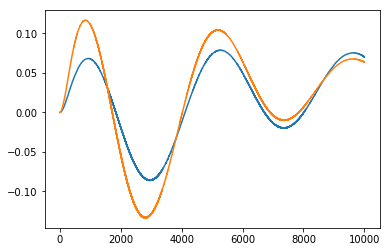

In [153]:
plt.plot(time[1000.],spin[1000.][2])
plt.plot(time[2000.],spin[2000.][2])

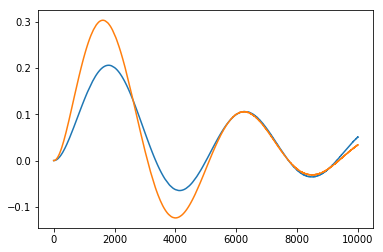

In [154]:
plt.plot(time[1000.],spin[1000.][1])
plt.plot(time[2000.],spin[2000.][1])

In [ ]:
#######################################################################

In [56]:
result = code.run(inputs=[rt_input],names=[name],run_dir=kpoints[k]['run_dir'])
result

Executing command: cd RT_T4.36; mpirun -np 8 yambo_rt -F int_1000.0-kpoint_kmax-simTime_10.in -J int_1000.0-kpoint_kmax-simTime_10 -C int_1000.0-kpoint_kmax-simTime_10
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0

{'output': [['RT_T4.36/int_1000.0-kpoint_kmax-simTime_10/o-int_1000.0-kpoint_kmax-simTime_10.polarization',
   'RT_T4.36/int_1000.0-kpoint_kmax-simTime_10/o-int_1000.0-kpoint_kmax-simTime_10.spin_magnetization',
   'RT_T4.36/int_1000.0-kpoint_kmax-simTime_10/o-int_1000.0-kpoint_kmax-simTime_10.orbt_magnetization',
   'RT_T4.36/int_1000.0-kpoint_kmax-simTime_10/o-int_1000.0-kpoint_kmax-simTime_10.current',
   'RT_T4.36/int_1000.0-kpoint_kmax-simTime_10/o-int_1000.0-kpoint_kmax-simTime_10.carriers',
   'RT_T4.36/int_1000.0-kpoint_kmax-simTime_10/o-int_1000.0-kpoint_kmax-simTime_10.external_field']],
 'dbs': ['RT_T4.36/int_1000.0-kpoint_kmax-simTime_10']}

In [57]:
data = P.YamboParser(result['output'][0])
data.keys()

dict_keys(['polarization', 'spin_magnetization', 'orbt_magnetization', 'current', 'carriers', 'external_field'])

In [58]:
field = data['external_field']
carriers = data['carriers']
spin = data['spin_magnetization']

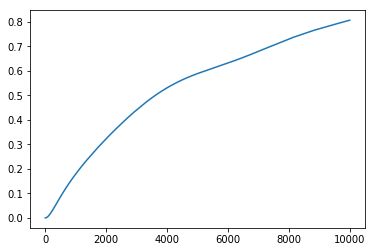

In [59]:
plt.plot(carriers['time'],carriers['dne'])

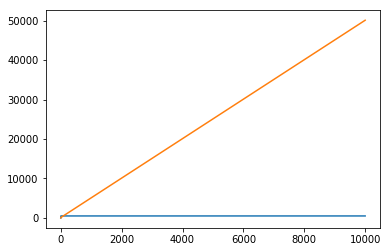

In [60]:
plt.plot(field['time'],field['Intensity'])
plt.plot(field['time'],10*field['Fluence'])

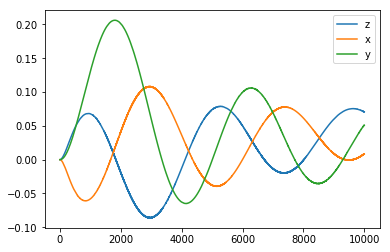

In [67]:
plt.plot(spin['time'],carriers['dne']*spin['Mc_z'],label='z')
plt.plot(spin['time'],carriers['dne']*spin['Mc_x'],label='x')
plt.plot(spin['time'],carriers['dne']*spin['Mc_y'],label='y')
#plt.hlines(0.5,-10,1100,linestyles='--')
#plt.xlim(-10,1000)
plt.legend()